In [143]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

In [144]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file


In [145]:
N = 8192
num_width = 32

In [146]:
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [166]:
dma_prn_data = ol.dma_prn_data
dma_prn_config = ol.dma_prn_config
dma_iq_data = ol.dma_iq_data
dma_iq_config = ol.dma_iq_config
dma_ifft_config = ol.dma_ifft_config
dma_res_data = ol.dma_output

In [271]:
# testing with 2 waves of same frequency, known convolution
iq_data = allocate(N, dtype=np.uint32)
prn_data = allocate(N, dtype=np.uint32)
full_data = allocate(2*N, dtype=np.uint32)
for i in range(N):
#     iq_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x7FFF, np.sin(i*2*np.pi/N) * 0x7FFF, num_width // 2)
#     prn_data[i] = 0x00FF0000 if i<100 else 0
# # #     prn_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x7FFF, np.sin(i*2*np.pi/N) * 0x7FFF, num_width // 2)
    iq_data[i] = get_value_from_complex(np.random.randint(-0x7FFF, 0x7FFF), np.random.randint(-0x7FFF, 0x7FFF), num_width // 2)
    prn_data[i] = get_value_from_complex(np.random.randint(-0x7FFF, 0x7FFF), np.random.randint(-0x7FFF, 0x7FFF), num_width // 2)
    full_data[2*i] = iq_data[i]
    full_data[2*i+1] = prn_data[i]
res_data = allocate(2*N, dtype=np.uint32)

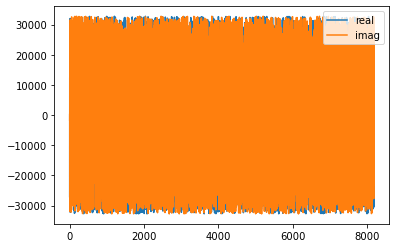

In [272]:
iq_data_components = get_components(iq_data, num_width // 2)
plt.plot(list(range(N)), iq_data_components['real'], label='real')
plt.plot(list(range(N)), iq_data_components['imag'], label='imag')
plt.legend()

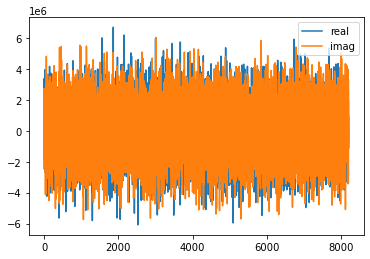

In [273]:
iq_fft = np.fft.fft(iq_data_components['real'] + iq_data_components['imag']*1j)
plt.plot(list(range(N)), iq_fft.real, label='real')
plt.plot(list(range(N)), iq_fft.imag, label='imag')
plt.legend()

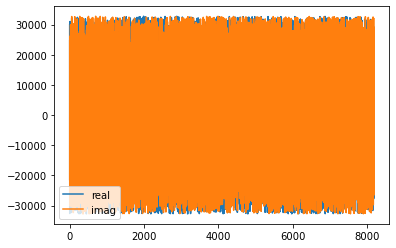

In [274]:
prn_data_components = get_components(prn_data, num_width // 2)
plt.plot(list(range(N)), prn_data_components['real'], label='real')
plt.plot(list(range(N)), prn_data_components['imag'], label='imag')
plt.legend()

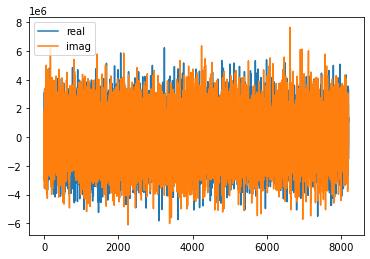

In [275]:
prn_fft = np.fft.fft(prn_data_components['real'] + prn_data_components['imag']*1j)                    
plt.plot(list(range(N)), prn_fft.real, label='real')
plt.plot(list(range(N)), prn_fft.imag, label='imag')
plt.legend()

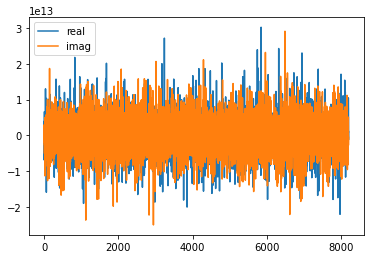

In [276]:
predicted_prod = iq_fft * prn_fft      
plt.plot(list(range(N)), predicted_prod.real, label='real')
plt.plot(list(range(N)), predicted_prod.imag, label='imag')
plt.legend()

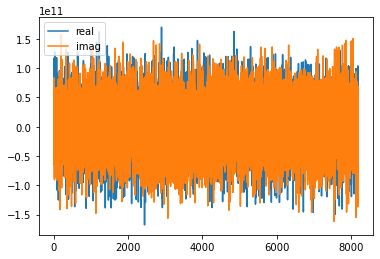

In [277]:
predicted_res = np.fft.ifft(iq_fft * prn_fft)                   
plt.plot(list(range(N)), predicted_res.real, label='real')
plt.plot(list(range(N)), predicted_res.imag, label='imag')
plt.legend()

In [278]:
# send configs to ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1

In [279]:
# # note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
# dma_ifft_config.sendchannel.transfer(ifft_config)
# dma_ifft_config.sendchannel.wait()

In [280]:
dma_iq_data.sendchannel.transfer(iq_data)
dma_iq_data.sendchannel.wait()

In [281]:
dma_prn_data.sendchannel.transfer(prn_data)
dma_prn_data.sendchannel.wait()

In [282]:
dma_res_data.recvchannel.transfer(res_data)
dma_res_data.recvchannel.wait()

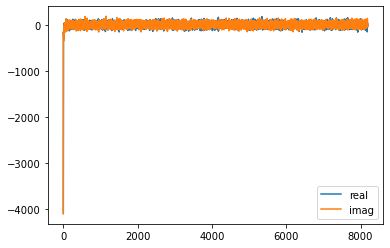

In [283]:
# 64 bit imprecision
real = res_data[0::2]
imag = res_data[1::2]
real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]

plt.plot(list(range(N)), real_decimal, label='real')
plt.plot(list(range(N)), imag_decimal, label='imag')
plt.legend()

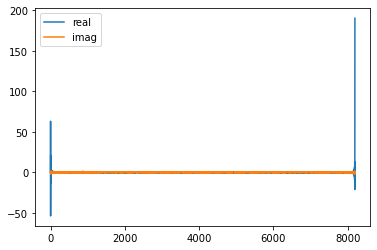

In [284]:
proposed_inputs = np.fft.ifft(components['real'] + components['imag']*1j)
plt.plot(list(range(N)), proposed_inputs.real, label='real')
plt.plot(list(range(N)), proposed_inputs.imag, label='imag')
plt.legend()